# Weather Classification- Good Day for a BBQ?

### Lynn Anderson

# Overview

The objective of this project was to find the best classification model for predicting BBQ weather 
Find most weather important factors


# Business Understanding

All Fired Up is a renowned barbeque and grill restaurant located in London, UK. They serve food from their kitchen every day, and recently started offering an outdoor area featuring freshly grilled food from hardwood lump charcoal. Their outdoor charcoal grilled foods have quickly become a huge hit, and on certain days get lots more business. However, on other days, hardly any people line up, or the grills fail to run properly. Weather seems to be a huge factor. Setting up the outdoor charcoal grills takes a lot of time and resources, so it is only worth it to fire up the charcoal and run the grill if it is nearly certain to be a nice day for barbequing. However, they also lose out on profits by not running the outdoor grill, since it attracts many more customers and they can charge a higher price. 

Thus, it will be important for my classification model to have a very low rate of false positive errors (ie a predicted 'good' day that is actually not suitable for a bbq), but not entirely at the expense of a large number of false negatives. For my evaluation metric, I am primarily concerned with the F1 score, since it represents the mean of the precesion and recall, and is a better metric on imbalanced datasets than accuracy or AUC. I will also be considering precision when evaluating models, since a high precision indicates the model predicts few false positives. ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision) 


# Data Understanding

The dataset consisted of two csv files- one containing records for in different cities, and the other with boolean values for whether it was a good bbq day. Both datasets contained 3,654 entries, each representing a day that weather information was recorded. I was only interested in data related to the Heathrow meteorological stations, so removed irrelevant columns and merged the two dataframes before performing any exploratory analysis or modeling. 

# Data Preparation

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix, mean_squared_error, roc_curve, auc
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, 
    RFE, RFECV)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# read in weather records 
df = pd.read_csv('data/weather_prediction_dataset.csv')
df.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


Each row contains weather related data for 18 different locations from a specific date.

In [3]:
# read in associated bbq labels
df_labels = pd.read_csv('data/weather_prediction_bbq_labels.csv')
df_labels.head()

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,20000101,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000102,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,20000103,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,20000104,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,20000105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Each row contains information regarding whether or not it was suitable for a bbq in a specific location on that day.

In [4]:
#verify date columns from both dataframes are identical
sum(df_labels['DATE'] != df['DATE'])

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(150), int64(15)
memory usage: 4.6 MB


The full dataset contains 165 columns and 3,654 rows. Before any modeling, I will be removing columns not related to Heathrow weather.

In [6]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   DATE                    3654 non-null   int64
 1   BASEL_BBQ_weather       3654 non-null   bool 
 2   BUDAPEST_BBQ_weather    3654 non-null   bool 
 3   DE_BBQ_weather          3654 non-null   bool 
 4   DRESDEN_BBQ_weather     3654 non-null   bool 
 5   DUSSELDORF_BBQ_weather  3654 non-null   bool 
 6   HEATHROW_BBQ_weather    3654 non-null   bool 
 7   KASSEL_BBQ_weather      3654 non-null   bool 
 8   LJUBLJANA_BBQ_weather   3654 non-null   bool 
 9   MAASTRICHT_BBQ_weather  3654 non-null   bool 
 10  MALMO_BBQ_weather       3654 non-null   bool 
 11  MONTELIMAR_BBQ_weather  3654 non-null   bool 
 12  MUENCHEN_BBQ_weather    3654 non-null   bool 
 13  OSLO_BBQ_weather        3654 non-null   bool 
 14  PERPIGNAN_BBQ_weather   3654 non-null   bool 
 15  SONNBLICK_BBQ_weather

I will be looking at Heathrow bbq weather as my target variable. All values besides date are of type boolean. 

In [7]:
# investigate all columns
list(df.columns)

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_max',
 'DE_BILT_cloud_cover',
 'DE_BILT_wind_speed',
 'DE_BILT_wind_gust',
 'DE_BILT_humidity',
 'DE_BILT_pressure',
 'DE_BILT_global_radiation',
 'DE_BILT_precipitation',
 'DE_BILT_sunshine',
 'DE_BILT_temp_mean',
 'DE_BILT_temp_min',
 'DE_BILT_temp_max',
 'DRESDEN_cloud_cover',
 'DRESDEN_wind_speed',
 'DRESDEN_wind_gust',
 'DRESDEN_humidity',
 'DRESDEN_global_radiation',
 'DRESDEN_precipitation',
 'DRESDEN_sunshine',
 'DRESDEN_temp_mean',
 'DRESDEN_temp_min',
 'DRESDEN_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_wind_speed',
 'DUSSELDORF_wind_gust',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pres

I am interested in the columns containing data for Heathrow. I will select only those and make a new dataframe.

In [8]:
# dataframe with only info pertaining to Heathrow

base_df_heathrow = df[['DATE', 'MONTH', 'HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_pressure',
                 'HEATHROW_global_radiation', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean',
                 'HEATHROW_temp_min', 'HEATHROW_temp_max']]

# add HEATHROW_BBQ_weather column to dataframe, joining on "DATE" column

base_df_heathrow = base_df_heathrow.merge(df_labels[['HEATHROW_BBQ_weather', "DATE"]], on="DATE", how="left")
base_df_heathrow.head()

,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
0,20000101,1,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,False
1,20000102,1,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,False
2,20000103,1,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,False
3,20000104,1,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,False
4,20000105,1,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,False


Now I have a dataframe containing all relevant information.

In [9]:
# check datatypes
base_df_heathrow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3654 entries, 0 to 3653
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DATE                       3654 non-null   int64  
 1   MONTH                      3654 non-null   int64  
 2   HEATHROW_cloud_cover       3654 non-null   int64  
 3   HEATHROW_humidity          3654 non-null   float64
 4   HEATHROW_pressure          3654 non-null   float64
 5   HEATHROW_global_radiation  3654 non-null   float64
 6   HEATHROW_precipitation     3654 non-null   float64
 7   HEATHROW_sunshine          3654 non-null   float64
 8   HEATHROW_temp_mean         3654 non-null   float64
 9   HEATHROW_temp_min          3654 non-null   float64
 10  HEATHROW_temp_max          3654 non-null   float64
 11  HEATHROW_BBQ_weather       3654 non-null   bool   
dtypes: bool(1), float64(8), int64(3)
memory usage: 346.1 KB


All columns are numeric except for the target variable, which is a boolean. However, the month column should be categorical, as assigning numeric values to the months could interfere with the modeling. I will replace the numbers with the appropriate month names.

In [10]:
# create dictinary for the months

month_labels = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August',
                9: 'September', 10: 'October', 11: 'November', 12: 'December'}


# replace dataframe column with month name
base_df_heathrow['MONTH'].replace(month_labels, inplace=True)
base_df_heathrow

,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
0,20000101,January,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,False
1,20000102,January,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,False
2,20000103,January,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,False
3,20000104,January,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,False
4,20000105,January,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,December,2,0.90,1.0043,0.37,0.06,3.7,1.7,-2.2,5.0,False
3650,20091229,December,8,0.92,0.9949,0.12,1.28,0.0,1.9,-1.2,5.2,False
3651,20091230,December,8,0.97,0.9923,0.12,0.36,0.0,4.6,4.0,4.4,False
3652,20091231,December,7,0.83,0.9993,0.13,0.00,0.0,3.9,3.3,3.6,False


In [11]:
# investigate "MONTH" column
base_df_heathrow['MONTH'].value_counts()

January      311
March        310
May          310
July         310
August       310
October      310
December     310
April        300
June         300
September    300
November     300
February     283
Name: MONTH, dtype: int64

There does not appear to be any anomalies with the month column.

In [12]:
# basic statistics
base_df_heathrow.describe()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,5.272031,0.758358,1.015192,1.196970,0.178279,4.433498,11.822386,8.002737,15.637438
std,2.874287e+04,2.011846,0.102410,0.010561,0.881638,0.367572,3.982646,5.610018,5.230449,6.385440
min,2.000010e+07,0.000000,0.420000,0.971500,0.120000,0.000000,0.000000,-2.200000,-6.800000,0.200000
25%,2.002070e+07,4.000000,0.690000,1.009000,0.430000,0.000000,0.600000,7.600000,4.100000,10.800000
50%,2.004567e+07,6.000000,0.760000,1.016000,0.960000,0.020000,3.700000,11.700000,8.250000,15.400000
75%,2.007070e+07,7.000000,0.840000,1.022100,1.860000,0.180000,7.200000,16.300000,12.100000,20.500000
max,2.010010e+07,8.000000,1.000000,1.043800,3.490000,3.660000,15.500000,29.000000,20.600000,37.900000


In [13]:
#check for null values
base_df_heathrow.isnull().sum()

DATE                         0
MONTH                        0
HEATHROW_cloud_cover         0
HEATHROW_humidity            0
HEATHROW_pressure            0
HEATHROW_global_radiation    0
HEATHROW_precipitation       0
HEATHROW_sunshine            0
HEATHROW_temp_mean           0
HEATHROW_temp_min            0
HEATHROW_temp_max            0
HEATHROW_BBQ_weather         0
dtype: int64

There are no null values to deal with.

In [14]:
# check porportions of target variable
base_df_heathrow['HEATHROW_BBQ_weather'].value_counts()

False    2785
True      869
Name: HEATHROW_BBQ_weather, dtype: int64

The weather was suitable for a bbq on about 24% of the recorded dates. This is not extremely imbalanced but, but it will be necessary to keep in mind that a 'dummy' model that always predicts False will be correct just over 75% of the time.

# Data Visualization

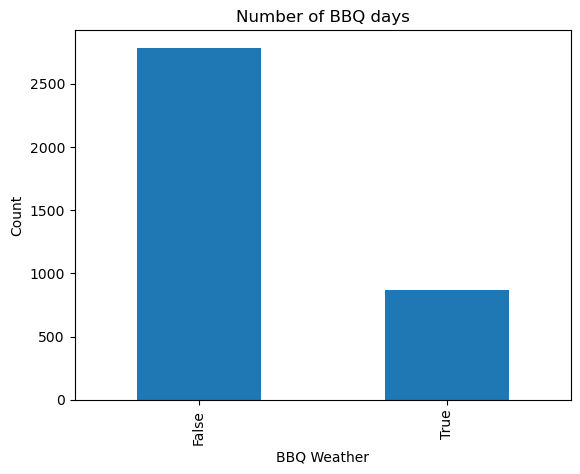

In [15]:
# barplot to visualize true and false ratios
base_df_heathrow['HEATHROW_BBQ_weather'].value_counts().plot.bar(title='Number of BBQ days', ylabel='Count').set_xlabel('BBQ Weather');

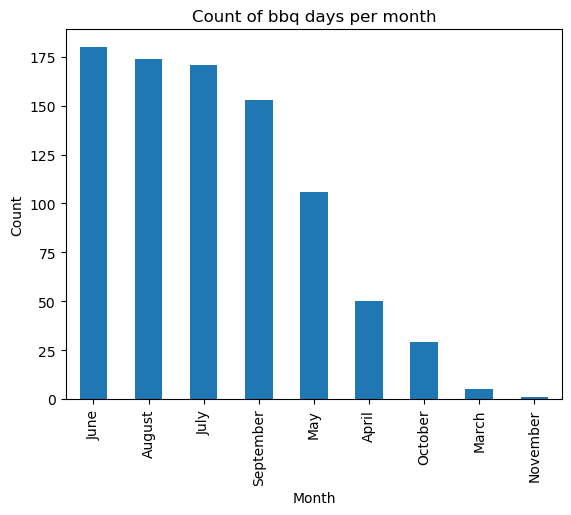

In [16]:
# plot number of good bbq weather days by month

bbq = base_df_heathrow.loc[base_df_heathrow['HEATHROW_BBQ_weather'] == True]
bbq['MONTH'].value_counts().plot.bar(title='Count of bbq days per month', ylabel='Count').set_xlabel('Month');

Not surprisingly, the summer months had by far the highest number of good bbq days. November and March had very few.

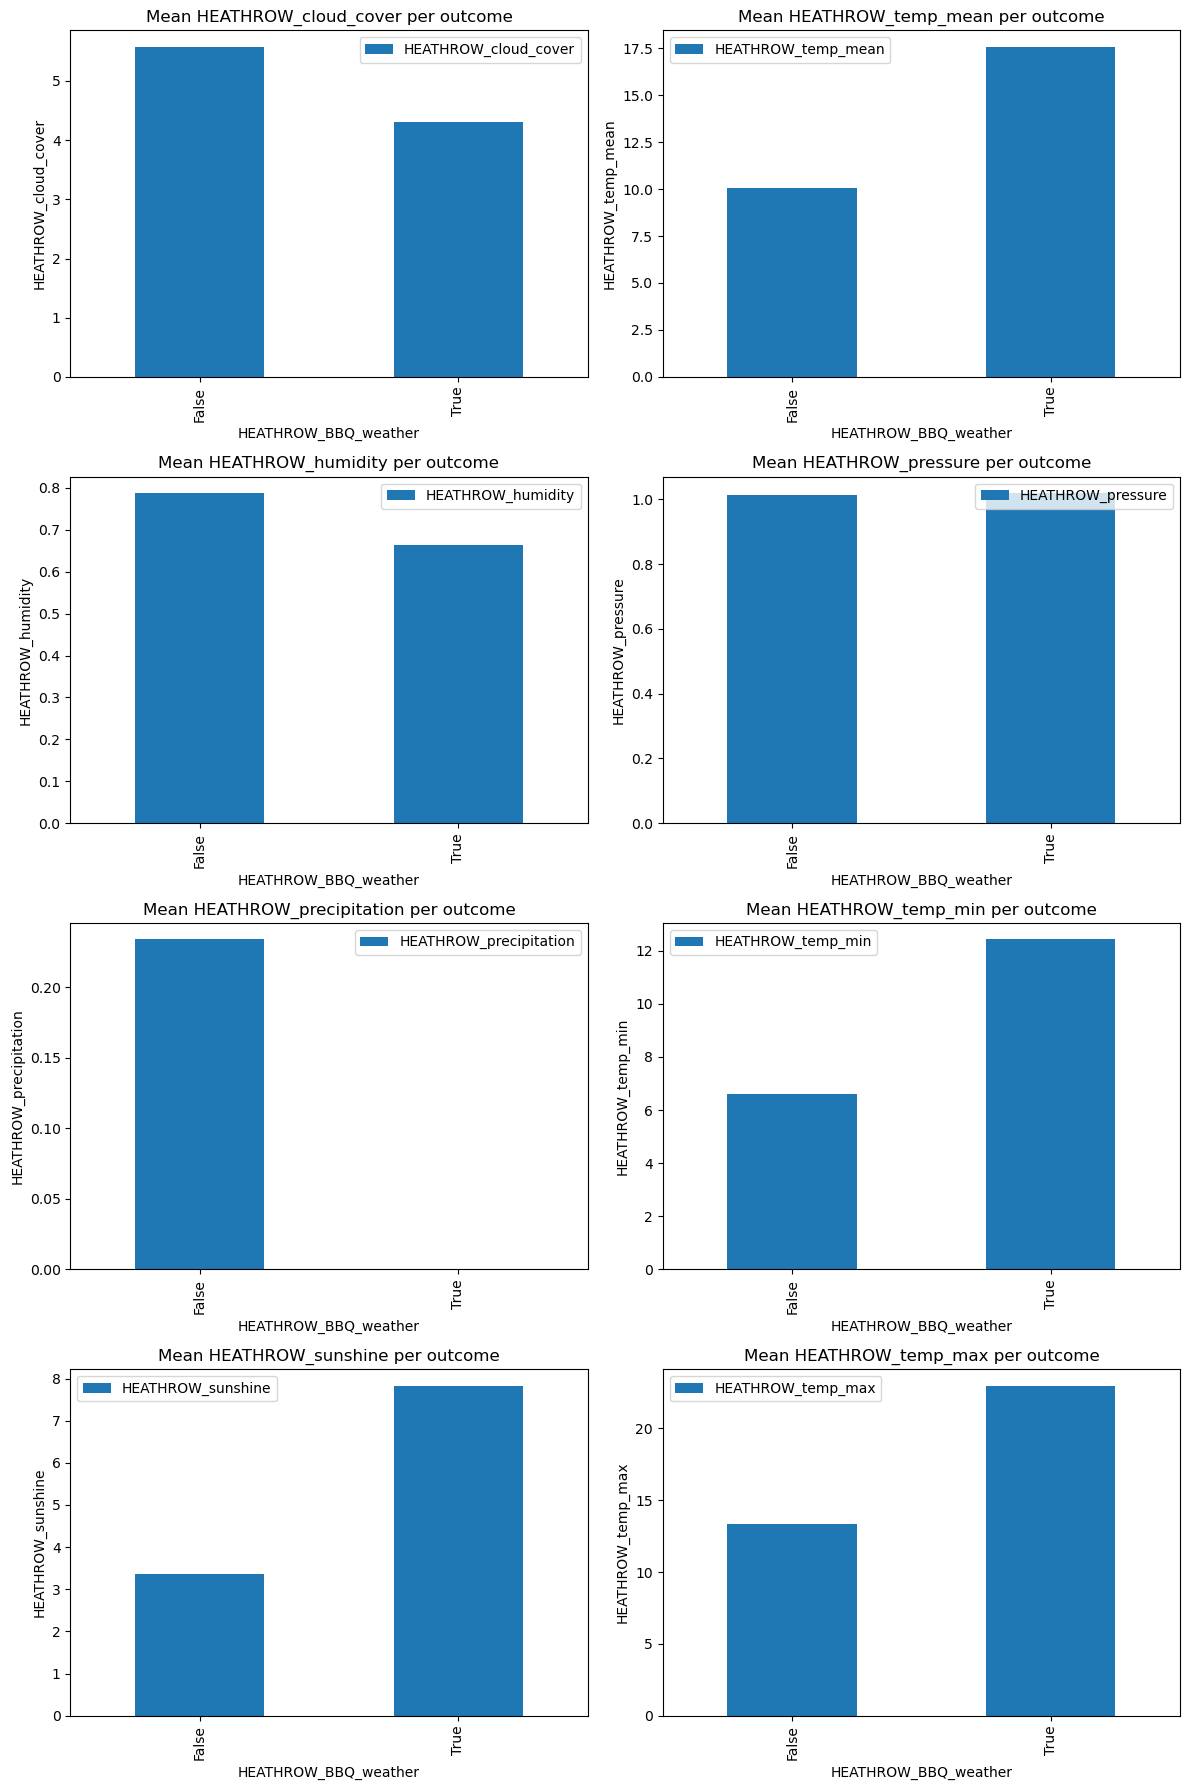

In [17]:
# visualize column data per outcome

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,18))
for i, col in enumerate(['HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean', 'HEATHROW_pressure', 'HEATHROW_temp_min', 'HEATHROW_temp_max']):
    base_df_heathrow.groupby('HEATHROW_BBQ_weather').mean().plot.bar(y=col, ylabel=col, title= 'Mean ' + col + ' per outcome', ax=axes[i%4][i//4]);
plt.tight_layout();

Just from observing the plots, it is obvious precipitation plays a huge role. Temperature and sunshine also look to play a significant role, while cloud cover and pressure do not seem to affect the outcome much. 

# Modeling

I am now going to investigate different types of models and evaluate their performance. First, I need to make dummy columns for each month, define X and y, and subsequently split the data into training and test sets before proceding. 

In [18]:
# get dummy columns for month
df_heathrow = pd.get_dummies(base_df_heathrow)
df_heathrow.head()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,...,MONTH_December,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,MONTH_November,MONTH_October,MONTH_September
0,20000101,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,...,0,0,1,0,0,0,0,0,0,0
1,20000102,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,...,0,0,1,0,0,0,0,0,0,0
2,20000103,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,...,0,0,1,0,0,0,0,0,0,0
3,20000104,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,...,0,0,1,0,0,0,0,0,0,0
4,20000105,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,...,0,0,1,0,0,0,0,0,0,0


In [19]:
# define X and y
X = df_heathrow.drop(['DATE', 'HEATHROW_BBQ_weather'],axis=1)
y = df_heathrow['HEATHROW_BBQ_weather']

#### Train-test split

In [20]:
# split data into train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

The data is now ready for classification modeling.

### Basic logistic regression model

In [21]:
# instantiate model 

logreg = LogisticRegression(fit_intercept=False, C=1, solver='liblinear')

# Fit to training data
log_model = logreg.fit(X_train, y_train)
log_model

LogisticRegression(C=1, fit_intercept=False, solver='liblinear')

#### Model evaluation

In [22]:
# get predicted y values and evaluate

log_model_y_pred = log_model.predict(X_test)

print(classification_report(y_test, log_model_y_pred))
print("F1 score: ", f1_score(y_test, log_model_y_pred))

              precision    recall  f1-score   support

       False       0.94      0.97      0.96       548
        True       0.90      0.83      0.86       183

    accuracy                           0.93       731
   macro avg       0.92      0.90      0.91       731
weighted avg       0.93      0.93      0.93       731

F1 score:  0.8628571428571429


The basic logistic regression model has an F1 score of 0.86 and precision of 0.9. These are overall good scores, but can certainly be improved upon. 

In [23]:
# investigate AUC for train and test data
log_model_y_train_score = logreg.decision_function(X_train)
log_model_y_test_score = logreg.decision_function(X_test)
log_model_y_pred = log_model.predict(X_test)
log_model_train_fpr, log_model_train_tpr, log_model_train_thresholds = roc_curve(y_train, log_model_y_train_score)
log_model_test_fpr, log_model_test_tpr, log_model_test_thresholds = roc_curve(y_test, log_model_y_test_score)

print('Train AUC: {}'.format(auc(log_model_train_fpr, log_model_train_tpr)))
print('Test AUC: {}'.format(auc(log_model_test_fpr, log_model_test_tpr)))



Train AUC: 0.9785439943906549
Test AUC: 0.9835566989749113


The AUC scores are very high. However, as the dataset is somewhat imbalanced, AUC may not be the best metric.

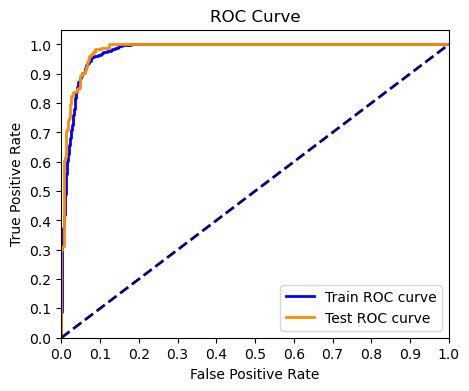

In [24]:

#plot roc auc 
plt.figure(figsize=(5, 4))
lw = 2

plt.plot(log_model_train_fpr, log_model_train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(log_model_test_fpr, log_model_test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/10.0 for i in range(11)])
plt.xticks([i/10.0 for i in range(11)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

There does not appear to be much  difference in the training and test data.

In [25]:
c_vals = [1, 5, 10, 50, 100]
best_C = None 
best_score = 0.0

for n in c_vals:
    
    logreg = LogisticRegression(fit_intercept=False, C=n, solver='liblinear')
    lr_model = logreg.fit(X_train, y_train)
    
    y_pred = lr_model.predict(X_test)
    f1 =  f1_score(y_test, y_pred)
    print("C value:", n, ". F1 score: ", f1)
    if f1 > best_score:
        best_C = n
        best_score = f1
    

print("\n" "Best C value: ", best_C, ". Best f1 score ", best_score)

C value: 1 . F1 score:  0.8628571428571429
C value: 5 . F1 score:  0.8926553672316384
C value: 10 . F1 score:  0.9070422535211268
C value: 50 . F1 score:  0.9411764705882353
C value: 100 . F1 score:  0.9526462395543176

Best C value:  100 . Best f1 score  0.9526462395543176


Increasing C (less regularization and more value to training data) seems to have increase performance. I will now investigate other types of models. If all other models perform pooror than the logistic regression, I will return to it and experiment with altering the penalty type or solver.

### K-Nearest Neighbors

Next I will look at a K-Nearest Neighbors (KNN) model. The KNN algorithm examines the labels of a chosen number of known data points surrounding a target data point, in order to make a prediction about the class that the target data point falls into. Because it is based on distance, it is important to standardize the data. 

In [26]:
# data must be scaled
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_X_train, columns=X.columns)
scaled_df_train.head()

,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,MONTH_April,...,MONTH_December,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,MONTH_November,MONTH_October,MONTH_September
0,0.870739,0.798819,-0.752802,-0.425281,-0.366392,-1.014606,0.463634,0.845271,0.119255,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,-0.296362,-0.304484,-0.306492
1,-0.120564,-0.171650,-2.758235,-0.504851,-0.204199,-0.712971,-0.319709,-0.530019,-0.239577,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,3.313534,-0.307159,-0.296362,-0.304484,-0.306492
2,-1.607518,-1.918495,0.019243,1.291168,-0.474521,1.850919,-0.853807,-1.370474,-0.379990,3.358796,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,-0.296362,-0.304484,-0.306492
3,0.870739,0.022444,-0.263213,-0.766297,-0.474521,-0.134839,-0.123874,0.176727,-0.801227,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,3.374254,-0.304484,-0.306492
4,0.375088,1.284054,1.214970,-1.027743,-0.474521,-1.014606,-0.925020,-1.294069,-0.582808,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,3.374254,-0.304484,-0.306492


In [27]:
# instantiate KNN model
knn = KNeighborsClassifier()

# Fit the classifier
knn.fit(scaled_X_train, y_train)



KNeighborsClassifier()

#### Model evaluation

In [28]:
# Predict on the test set and evaluate
knn_test_preds = knn.predict(scaled_X_test)

print(classification_report(y_test, knn_test_preds))

print("F1 score: ", f1_score(y_test, knn_test_preds))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94       548
        True       0.83      0.81      0.82       183

    accuracy                           0.91       731
   macro avg       0.88      0.88      0.88       731
weighted avg       0.91      0.91      0.91       731

F1 score:  0.8176795580110497


The F1 score of 0.82 and precision of 0.83 are lower than the basic logistic regression model. Perhaps altering some parameters will imporove model performance.

In [29]:
# Check the AUC of predictions
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_test_preds)
knn_auc = auc(knn_fpr, knn_tpr)
knn_auc

0.8760869131666069

The AUC is also lower than the logistic regression model.

In [30]:
# iterate over k values and find best model

k_vals = range(1, 25, 2)
best_k = 0
best_score = 0.0
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaled_X_train, y_train)
    preds = knn.predict(scaled_X_test)
        
    f1 = f1_score(y_test, preds)
    
    if f1 > best_score:
        best_k = k
        best_score = f1
        
    
print("Best Value for k: {}".format(best_k))
print("F1-Score: {}".format(best_score))


Best Value for k: 7
F1-Score: 0.8453038674033149


A value of 7 for the number of neighbors produced the highest F1 score. This is still lower than any logistic regression models. Next, I will investigate another type of model, decesion trees and other algorithms based off them.  

In [31]:
knn2 = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier
knn2.fit(scaled_X_train, y_train)


# Predict on the test set
knn2_test_preds = knn2.predict(scaled_X_test)

In [32]:
print(classification_report(y_test, knn2_test_preds))

              precision    recall  f1-score   support

       False       0.95      0.95      0.95       548
        True       0.85      0.84      0.85       183

    accuracy                           0.92       731
   macro avg       0.90      0.89      0.90       731
weighted avg       0.92      0.92      0.92       731



### Basic decision tree classifier

A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

In [33]:
# instantiate model
dt = DecisionTreeClassifier()

#fit to training data
dt.fit(X_train, y_train)

DecisionTreeClassifier()

#### Model evaluation

In [34]:
# predict y values and evaluate

dt_y_pred = dt.predict(X_test)

print(classification_report(y_test, dt_y_pred))
print("F1 score: ", f1_score(y_test, dt_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


This model has a perfect F1 score on the dataset. While this certainly does happen, I will still investigate further and look at more complex models. 

In [35]:
# Check the AUC 
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, dt_y_pred)
dt_auc = auc(dt_fpr, dt_tpr)
dt_auc

1.0

The AUC is also perfect. I am now going to visually inspect the tree.

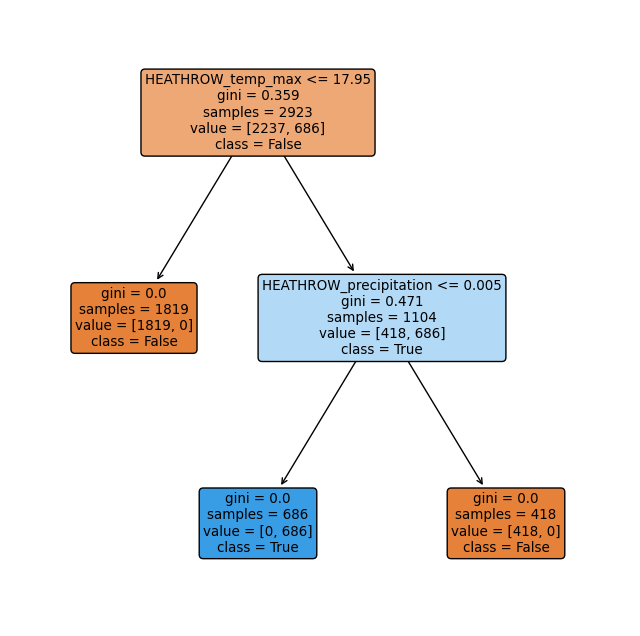

In [36]:
# Plot and show decision tree
plt.figure(figsize=(8, 8))
tree.plot_tree(dt, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()


Max temperature and precipitation amount appear to be the deciding factors in whether or not it will be suitable for an outdoor BBQ. From the bar charts above, this is not particularily surprising, given that the min, mean, and max temperature are all very closely related, as would precipitation and sunshine. 

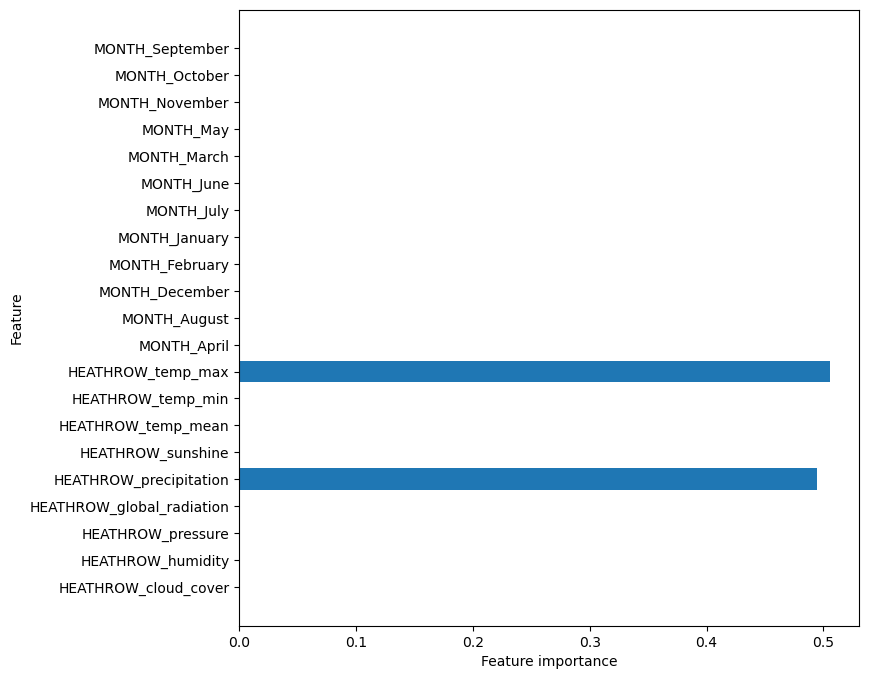

In [37]:
# plot the feature importances

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dt)

Again it is clear max temperature and precipitation are the primary factors. 

### Random forest classifier

I am now going to look at a random forest model. A random forest algorithm is essentially an ensemble of decision trees. randomly select a subset of features to use as predictors for each node when training a decision tree, instead of using all predictors available at each node. 

In [38]:
# instantiate and fit model

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

#### Model evaluation

In [39]:
# predict and evaluate

forest_y_pred = forest.predict(X_test)

print(classification_report(y_test, forest_y_pred))
print("F1 score: ", f1_score(y_test, forest_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


As could be expected based on the basic decesion tree, this model also has a perfect f1 score. 

In [40]:
# AUC 
forest_fpr, forest_tpr, thresholds = roc_curve(y_test, forest_y_pred)
forest_auc = auc(forest_fpr, forest_tpr)
forest_auc

1.0

The random forest model is also a great model for this specific dataset. 

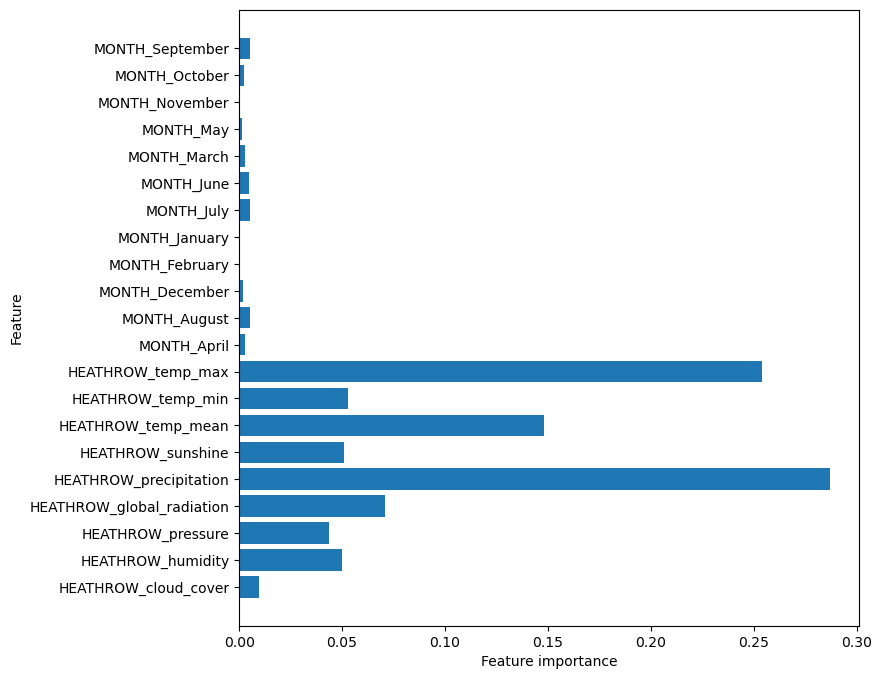

In [41]:
# plot feature importances
plot_feature_importances(forest)

Max temp and precipitatin are still by far the most important. However, since not all trees were given these two features, it is now apparent that other features have some importance- besides temperature, humidity, sunshine, and radiation had noteable impacts. 

### Bagged tree

In [42]:
# instantiate

bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

#### Model evaluation

In [43]:
bt_y_pred = bagged_tree.predict(X_test)

print(classification_report(y_test, bt_y_pred))
print("F1 score: ", f1_score(y_test, bt_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


In [44]:

# Check the AUC of predictions
bt_fpr, bt_tpr, thresholds = roc_curve(y_test, bt_y_pred)
bt_roc_auc = auc(bt_fpr, bt_tpr)
bt_roc_auc

1.0

#### Random Forest using grid search to find optimal parameters

In [45]:


param_grid = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
forest_grid_search = GridSearchCV(forest, param_grid, cv=3)
forest_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {forest_grid_search.best_score_ :.2%}")


print("")
print(f"Optimal Parameters: {forest_grid_search.best_params_}")

Testing Accuracy: 99.97%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [46]:
best_rf = RandomForestClassifier(criterion='entropy',  max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)
best_rf.fit(X_train, y_train)
best_rf_y_pred = best_rf.predict(X_test)

print(classification_report(y_test, best_rf_y_pred))
print("F1 score: ", f1_score(y_test, best_rf_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


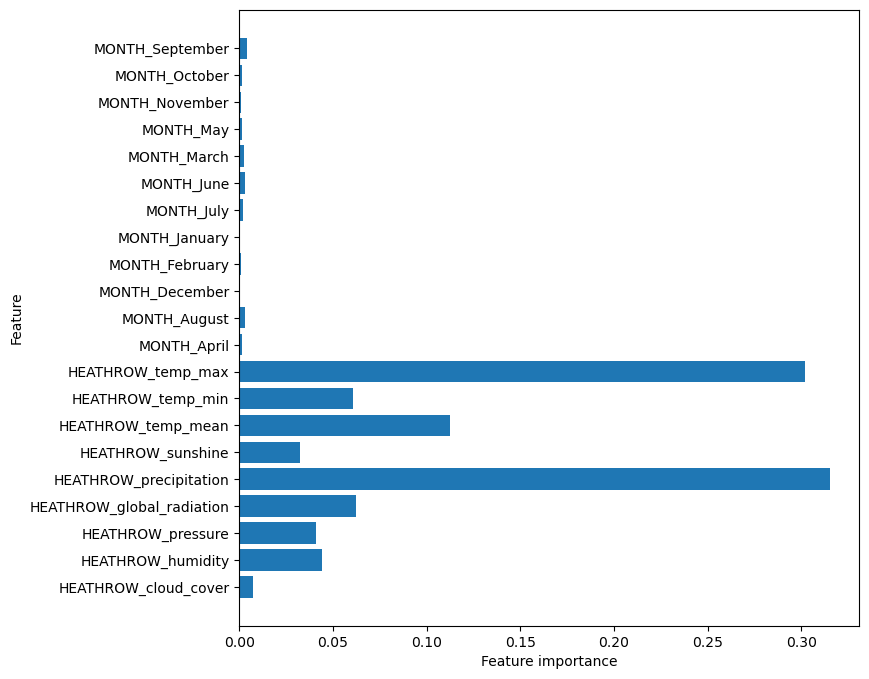

In [47]:
plot_feature_importances(best_rf)

# Evaluation

The basic decesion tree model, and subsequent more complex models based off decesion trees- the random forest and grid search tuned random forest- far outperformed the logistic regression and K Nearest Neighbors models. While decesion trees can often tend to overfit training data and be more affected by outliers, in this case the decesion tree performed just as good as the more complex models. Since a random forest or bagged tree is much more complex and computationally expensive than a decesion tree, for this dataset the decesion tree is the best model in terms of overall performance and computational complexity. 

# Conclusions

Max temperature and precipitation are by far the most important factors to consider when deciding whether or not to fire up the outdoor charcoal grills. Since temperature for a given day is easier to predict than knowing if it will rain, further attention should be directed towards weather models that accurately predict if the area will receive significant rain. 

# Next Steps and Limitations

Temperature for a given day is easier to predict than knowing if it will rain. Wind is likely a factor. Data is older, climate change and shifting weather patterns may influence. 

